# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [2]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [3]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you. 
"""
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [4]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

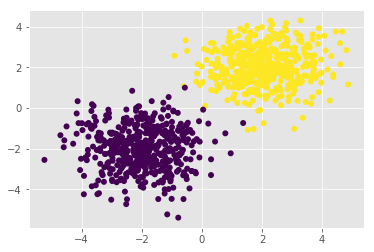

In [5]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]

Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [6]:
#criterion = ClassNLLCriterion()
criterion = MSECriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(4, 2))
net.add(SoftMax())

print(net)

Linear 2 -> 4
BatchMeanNormalization
ReLU
Linear 4 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [7]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [8]:

# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

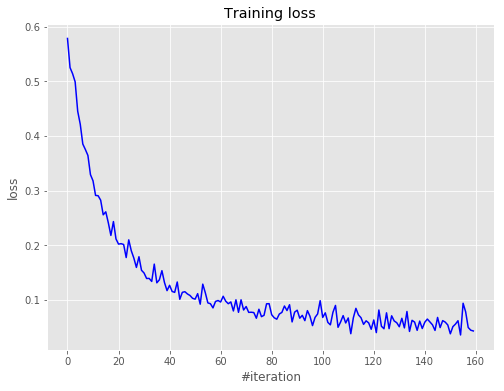

Current loss: 0.043036
3.0084409713745117


In [9]:
loss_history = []

t1=time()

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

print(time()-t1)

# REPORT:
1. Times of all activation functions almost same
2. CrossEntropy gives sharper convergency than MSE

.

.

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [10]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)


One-hot encode the labels first.

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
one_hot_y = np.array(enc.fit_transform(y.reshape(-1, 1)).todense())
print(one_hot_y[16000],y[16000])

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.] 2.0


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

#### Divide datat to train and test

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, one_hot_y, test_size = 0.2)

## NN without BatchMeanSubtraction

In [13]:
#criterion = MSECriterion()
criterion = ClassNLLCriterion()
# Test something like that then 

net_1 = Sequential()
net_1.add(Dropout())
net_1.add(Linear(784,250))
net_1.add(ReLU())
# net_1.add(Dropout())
net_1.add(Linear(250, 50))
net_1.add(ReLU())
# net_1.add(Dropout())
net_1.add(Linear(50, 10))
net_1.add(SoftMax())

In [14]:
# Optimizer params
optimizer_config_1 = {'learning_rate' : 1e-1, 'momentum': 0.7}
optimizer_state_1 = {}

# Looping params
n_epoch = 30
batch_size = 100

#### Training without BMS

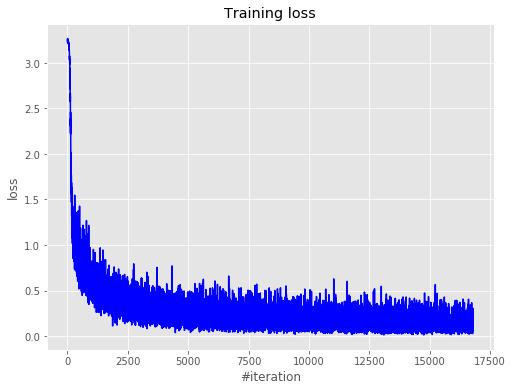

Current loss: 0.208691
Time: 3.3417504986127216 min


In [15]:
loss_history_net_1 = []
loss_history = []
start=time()
for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        mean_loss = []
        net_1.zeroGradParameters()
        
        # Forward
        predictions = net_1.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_1.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net_1.getParameters(), 
                     net_1.getGradParameters(), 
                     optimizer_config_1,
                     optimizer_state_1)      
        mean_loss.append(loss)
        loss_history.append(loss)
        
    loss_history_net_1.append(np.array(mean_loss).mean())
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, color = 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  
print("Time: "+str((time()-start)/60.0)+" min")

#### Accuracy calculation

In [16]:
from sklearn.metrics import accuracy_score
y_predict = net_1.forward(X_test, train=False) #'train=False' disables dropouts. See modules
accuracy_net_1 = accuracy_score(y_test.argmax(axis = 1),y_predict.argmax(axis = 1))
print('Accuracy of NN without BMS =','{:.2f}%'.format(accuracy_net_1*100))

Accuracy of NN without BMS = 96.38%


## NN with BatchMeanSubtraction

In [17]:
criterion = ClassNLLCriterion()

net_2 = Sequential()
net_2.add(Dropout())
net_2.add(Linear(784,250))
net_2.add(BatchMeanSubtraction())

net_2.add(ReLU())
# net_2.add(Dropout())
net_2.add(Linear(250, 50))

net_2.add(ReLU())
# net_2.add(Dropout())
net_2.add(Linear(50, 10))
net_2.add(SoftMax())

In [18]:
# Optimizer params
optimizer_config_2 = {'learning_rate' : 1e-1, 'momentum': 0.7}
optimizer_state_2 = {}

# Looping params
n_epoch = 30
batch_size = 100

#### Training with BMS

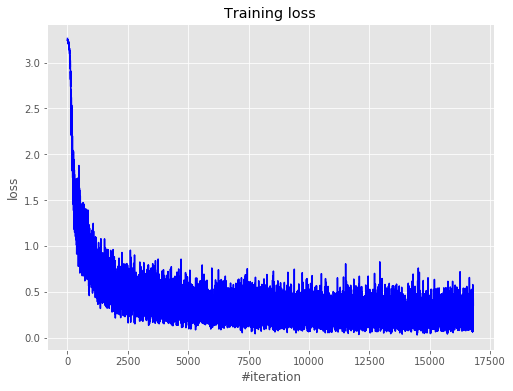

Current loss: 0.354132
Time: 3.215310780207316 min


In [19]:
loss_history_net_2 = []
loss_history = []

start=time()
for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        mean_loss = []
        net_1.zeroGradParameters()
        
        # Forward
        predictions = net_2.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_2.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net_2.getParameters(), 
                     net_2.getGradParameters(), 
                     optimizer_config_2,
                     optimizer_state_2)      
        mean_loss.append(loss)
        loss_history.append(loss)
        
    loss_history_net_2.append(np.array(mean_loss).mean())
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, color = 'b')
    plt.show()
    
    print('Current loss: %f' % loss)
print("Time: "+str((time()-start)/60.0)+" min")

#### Accuracy calculation

In [20]:
from sklearn.metrics import accuracy_score
y_predict = net_2.forward(X_test, train=False)
accuracy_net_2 = accuracy_score(y_test.argmax(axis = 1),y_predict.argmax(axis = 1))
print('Accuracy of NN with BMS =','{:.2f}%'.format(accuracy_net_2*100))

Accuracy of NN with BMS = 94.92%


## Comparision of losses from network_1 and network_2

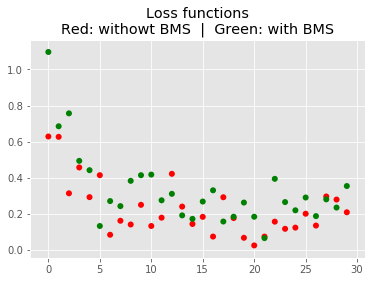

In [21]:
plt.scatter(range(0,n_epoch),loss_history_net_1,color = 'r', edgecolors= 'none')
plt.scatter(range(0,n_epoch),loss_history_net_2,color = 'g', edgecolors= 'none')
plt.title("Loss functions\nRed: withowt BMS  |  Green: with BMS")
plt.show()

# REPORT:
To understand effect of BMS, I take same NN-s of same LR-s. I didn't notice any adventage of BMS

 .

 .

# Autoencoder (optional) 

Follow the link: https://github.com/DanielBaghdasaryan/Session1/blob/master/assignment2_encoder.ipynb